# Training Notebook using Tensorflow
This notebook explores a model architecture ustilsing a Recurrent Neural Network with Gated Recurent Units.

A small subset of the training data is used to help ensure faster iterations.

In [1]:
import errno    
import os

# Helper Functions
def normalize(train):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    print("mean: %f"%mean)
    print("std: %f"%std)
    return train, mean, std

def normalize_with_paras(test, mean, std):
    test = (test - mean) / std
    return test

def next_batch(data, labels, current_batch, batch_size):
    start_idx = current_batch * batch_size
    end_idx = (current_batch + 1)*batch_size
    current_batch += 1
    return (current_batch, data[start_idx:end_idx], labels[start_idx:end_idx] )

def makedirs(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [2]:
# Data Preparation
import numpy as np
import os
mel_directory = r'/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5/'
# X_train_1 = np.load(os.path.join(mel_directory,"161225-001.wav-mel.npy")).astype(float).transpose(0,2,1)
# y_train_1 = np.load(os.path.join(mel_directory,"161225-001-mel-labels.npy")).astype(int)
X_train_2 = np.load(os.path.join(mel_directory,"161225-002.wav-mel.npy")).astype(float).transpose(0,2,1)
y_train_2 = np.load(os.path.join(mel_directory,"161225-002-mel-labels.npy")).astype(int)
X_train_4 = np.load(os.path.join(mel_directory,"161225-004.wav-mel.npy")).astype(float).transpose(0,2,1)
y_train_4 = np.load(os.path.join(mel_directory,"161225-004-mel-labels.npy")).astype(int)

# X_train_part = np.vstack((X_train_1, X_train_2))
X_train = np.vstack((X_train_2, X_train_4))

# del(X_train_1)
del(X_train_2)
del(X_train_4)
# del(X_train_part)

# y_train_part = np.concatenate((y_train_1,y_train_2), axis=0)
y_train = np.concatenate((y_train_2,y_train_4), axis=0)

# del(y_train_1)
del(y_train_2)
del(y_train_4)
# del(y_train_part)

X_test = np.load(os.path.join(mel_directory,"161225-003.wav-mel.npy")).astype(float).transpose(0,2,1)
y_test = np.load(os.path.join(mel_directory,"161225-003-mel-labels.npy")).astype(int)
X_train, mean, std = normalize(X_train)
X_test = normalize_with_paras(X_test, mean, std)

mean: -31.797126
std: 14.150785


In [3]:
print('training data shape:',X_train.shape)
print('training labels shape:',y_train.shape)
print('test data shape:',X_test.shape)
print('test labels shape:',y_test.shape)

('training data shape:', (10261, 351, 40))
('training labels shape:', (10261,))
('test data shape:', (5506, 351, 40))
('test labels shape:', (5506,))


In [4]:
# Baseline accuracy i.e. always choose the most frequent class
baseline_acc = 100-(100.0*np.sum(y_test)/y_test.shape[0])
print('Baseline accuracy: %0.2f. This is achieved by choosing the majority class.'%baseline_acc)

Baseline accuracy: 98.18. This is achieved by choosing the majority class.


# Model Construction
The following model is a Recurrent Neural Network (RNN) with Gated Recurrent Units (GRU) memory cells.

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.rnn import GRUCell
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir_train = "{}/run-{}-train/".format(root_logdir, now)
logdir_test = "{}/run-{}-test/".format(root_logdir, now)

tf.reset_default_graph()

n_inputs = 40
n_steps = 351

n_neurons = 32
n_layers = 2
n_fully_connected = 64
n_outputs = 2

learning_rate = 0.001
keep_prob = 0.5

epsilon = 0.00000001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs]) # n_steps is the number of time steps
y = tf.placeholder(tf.int64, [None])

# RNN(GRU) & fully connected layers
with tf.name_scope('rnn'):
    with tf.contrib.framework.arg_scope(
        [ fully_connected],
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
        
        cells=[]
        for _ in range(n_layers):
            cell = tf.contrib.rnn.DropoutWrapper(GRUCell(num_units=n_neurons), input_keep_prob=keep_prob)
            cells.append(cell)
        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=False)        
        outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
        FC_1_logits = fully_connected(states, n_fully_connected)
        logits = fully_connected(FC_1_logits, n_outputs, activation_fn=None)

# cost function
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)

# Gradient decent optimiser
with tf.name_scope('train'):    
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimiser.minimize(loss)

# evaluation using accuracy
with tf.name_scope('eval'):
    proba = tf.nn.softmax(logits, name='proba')
    predicted = tf.arg_max(proba,1)
    confusion = tf.confusion_matrix(labels=y, predictions=predicted)

    actual = y

    tp = tf.to_float(tf.count_nonzero(predicted * actual))
    tn = tf.to_float(tf.count_nonzero((predicted - 1) * (actual - 1)))
    fp = tf.to_float(tf.count_nonzero(predicted * (actual - 1)))
    fn = tf.to_float(tf.count_nonzero((predicted - 1) * actual))
    
    precision = tp /(tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    
    precision_summary = tf.summary.scalar('precision',precision)
    recall_summary = tf.summary.scalar('recall',recall)
    f1_summary = tf.summary.scalar('f1',f1)
    
    tp_summary = tf.summary.scalar('tp',tp)
    fp_summary = tf.summary.scalar('fp',fp)

    tn_summary = tf.summary.scalar('tn',tn)
    fn_summary = tf.summary.scalar('fn',fn)

    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    file_writer_train = tf.summary.FileWriter(logdir_train, tf.get_default_graph()) 
    file_writer_test = tf.summary.FileWriter(logdir_test, tf.get_default_graph()) 

# Model Execution

In [6]:
n_epochs = 100
batch_size = 50

saver = tf.train.Saver()
run_dir = "kws-{}".format(n_epochs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    best_f1 = -1
    
    for epoch in range(n_epochs):
        current_batch = 0
        for iteration in range(X_train.shape[0] // batch_size):
            current_batch, X_batch, y_batch = next_batch(X_train, y_train, current_batch, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        # Compute epoch metrics of interest to display in Tensorboard
        summary_train = sess.run(merged, {X: X_train, y: y_train})
        file_writer_train.add_summary(summary_train,epoch)
        file_writer_train.flush()
        
        summary_test = sess.run(merged, {X: X_test, y: y_test})
        file_writer_test.add_summary(summary_test,epoch)
        file_writer_test.flush()   
        
        # Compute epoch metrics of interest to print in this notebook 
        pred_train = predicted.eval(feed_dict={X: X_train, y: y_train})
        pred_test = predicted.eval(feed_dict={X: X_test, y: y_test})
        
        logits_train_vals = logits.eval(feed_dict={X: X_train, y: y_train})
        logits_test_vals = logits.eval(feed_dict={X: X_test, y: y_test})
        confusion_train = confusion.eval(feed_dict={logits: logits_train_vals, y: y_train})
        confusion_test = confusion.eval(feed_dict={logits: logits_test_vals, y: y_test})
        
        tp_val_test = tp.eval(feed_dict={predicted:pred_test, actual:y_test})
        tn_val_test = tn.eval(feed_dict={predicted:pred_test, actual:y_test})
        fp_val_test = fp.eval(feed_dict={predicted:pred_test, actual:y_test})
        fn_val_test = fn.eval(feed_dict={predicted:pred_test, actual:y_test})
        prec_val_test = precision.eval(feed_dict={tp:tp_val_test,fp:fp_val_test})
        rec_val_test = recall.eval(feed_dict={tp:tp_val_test,fn:fn_val_test})
        f1_score_test = f1.eval(feed_dict={precision:prec_val_test, recall:rec_val_test})
              
        print(epoch, "f1 test score:",f1_score_test)
        print("Train Confusion Matrix:")
        print(confusion_train)
        print("Test Confusion Matrix:")
        print(confusion_test)

        # Save best model so far
        model_dir = './saved models/{}'.format(run_dir)
        makedirs(model_dir)

        if f1_score_test > 0 and f1_score_test >= best_f1:
            now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
            fname = './{}/kws_model-{}-{}.ckpt'.format(model_dir,epoch,now)
            save_path = saver.save(sess, fname)
            best_f1 = f1_score_test
            print("Saved new best model with f1 score: %0.4f"%f1_score_test)
            
    file_writer_train.close()
    file_writer_test.close()

(0, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(1, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10060     1]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(2, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(3, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(4, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(5, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(6, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200     0]]
Test Confusion Matrix:
[[5406    0]
 [ 100    0]]
(7, 'f1 test score:', 0.0)
Train Confusion Matrix:
[[10061     0]
 [  200   

# Debugging
The following cell provides debug information from the model.

```
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    logits_vals = logits.eval(feed_dict={X:X_train[4500:4600],y:y_train[4500:4600]})
    y_vals = y.eval(feed_dict={y: y_train[4500:4600]})
    pred = predicted.eval(feed_dict={X:X_train[4500:4600],y:y_train[4500:4600]})
    tp_val = tp.eval(feed_dict={predicted:pred, actual:y_vals})
    tn_val = tn.eval(feed_dict={predicted:pred, actual:y_vals})
    fp_val = fp.eval(feed_dict={predicted:pred, actual:y_vals})
    fn_val = fn.eval(feed_dict={predicted:pred, actual:y_vals})
    confus = confusion.eval(feed_dict={logits:logits_vals, y: y_vals})
    prec_val = precision.eval(feed_dict={tp:tp_val,fp:fp_val})
    rec_val = recall.eval(feed_dict={tp:tp_val,fn:fn_val})
    f1_score = f1.eval(feed_dict={precision:prec_val, recall:rec_val})
    print(y_vals)
    print(pred)
    print(tp_val)
    print(tn_val)
    print(fp_val)
    print(fn_val)
    print(confus)
    print(prec_val)
    print(rec_val)
    print(f1_score)
```

# Generate a Prediction from a Saved Model
The model is not that great. It seems to detect birds outside more than the target class.

In [7]:
# look at an example input
from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

mel_directory = r'/Volumes/ThorsHammer/DataScience/data/audio-recognition/mel_3.5/'

# Learned Parameters from the training dataset
# mean= -26.215140
# std= 11.788497

mean = -31.797126
std = 14.150785

X_test = np.load(os.path.join(mel_directory,"161225-003.wav-mel.npy")).astype(float).transpose(0,2,1)
y_test = np.load(os.path.join(mel_directory,"161225-003-mel-labels.npy")).astype(int)
X_test = normalize_with_paras(X_test, mean, std)

# known positive class frame
i = 0
num = len(X_test)

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, r"./saved models/second/my_model_final.ckpt")
    X_raw = X_test[i:i+num].reshape(num,n_steps,n_inputs)
    X_feed = normalize_with_paras(X_raw, mean, std).astype('float32') # calculated above
    pred = predicted.eval(feed_dict={X:X_feed})
    print('prediction:',pred)
    print(sum(pred))


INFO:tensorflow:Restoring parameters from ./saved models/second/my_model_final.ckpt
('prediction:', array([0, 0, 0, ..., 0, 0, 0]))
12


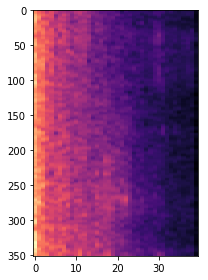

('Label:', 0)


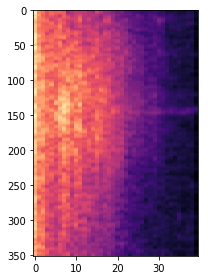

('Label:', 0)


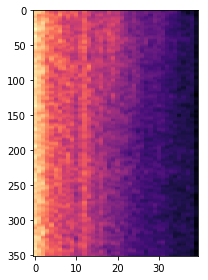

('Label:', 0)


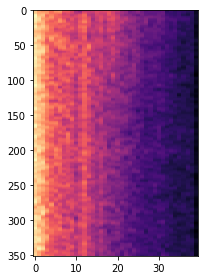

('Label:', 0)


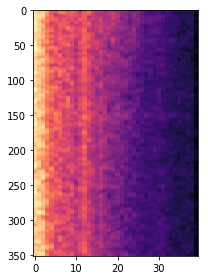

('Label:', 0)


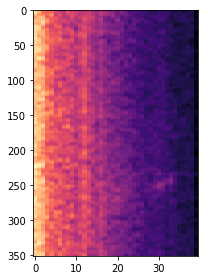

('Label:', 0)


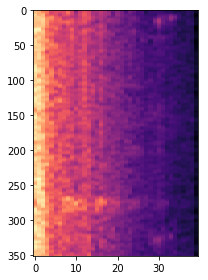

('Label:', 0)


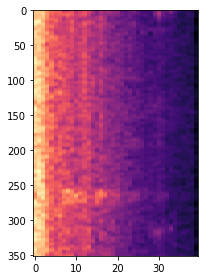

('Label:', 0)


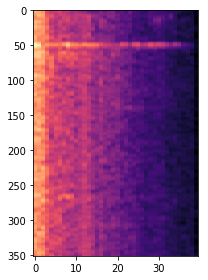

('Label:', 0)


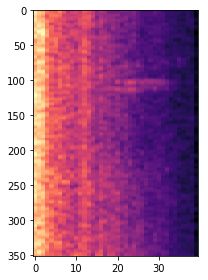

('Label:', 0)


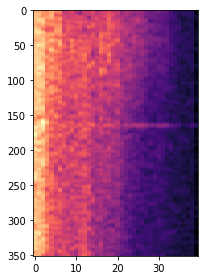

('Label:', 0)


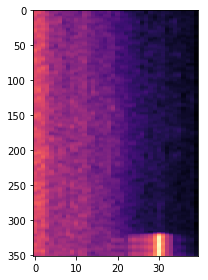

('Label:', 0)


In [8]:
idx = np.where(pred > 0)[0]
for i in idx:
    fig, ax = plt.subplots(figsize=(3, 4))
    ax.imshow(X_test[i], cmap=plt.cm.magma, interpolation='nearest', aspect='auto')
    plt.tight_layout()
    plt.show()
    print('Label:',y_test[i])

# TODOs
* Hyper parameter tuning
* More test data
* Augment data with copies of beeps